# Notebook 3: Lowest Order Rising Bubble

This notebook will demonstrate the use of the lowest-order finite element spaces. To increase the order of accuracy of the transport schemes, we use a recovered finite element method. The transported fields are recovered into a higher-order function space before the transport is performed.

We will demonstrate this 'recovery' concept by solving the compressible Euler equations to simulate a rising bubble, using the dry test of Bryan and Fritsch (2002): https://journals.ametsoc.org/view/journals/mwre/130/12/1520-0493_2002_130_2917_absfmn_2.0.co_2.xml.

As usual, we begin by importing the required functions from Firedrake and Gusto:

In [2]:
from gusto import *
from firedrake import (IntervalMesh, ExtrudedMesh,
                       SpatialCoordinate, conditional, cos, pi, sqrt,
                       TestFunction, dx, TrialFunction, Constant, Function,
                       LinearVariationalProblem, LinearVariationalSolver,
                       FunctionSpace, BrokenElement, VectorFunctionSpace)

We now define the time-step size and simulation time.

In [3]:
dt = 1.0
tmax = 1000.

We will contruct our two dimensional mesh by extruding a 1D `IntervalMesh`. Here we specify the length `L` and height `H` of the mesh and the grid size `deltax` which is the same in both the x and z directions.

In [4]:
L = 10000.
H = 10000.
deltax = 100.
nlayers = int(H/deltax)
ncolumns = int(L/deltax)
m = IntervalMesh(ncolumns, L)
mesh = ExtrudedMesh(m, layers=nlayers, layer_height=H/nlayers)

We will record the full velocity and perturbations to the potential temperature.

In [5]:
output = OutputParameters(dirname='dry_bf_bubble_recovered',
                          dumpfreq=int(tmax / (5*dt)),
                          dumplist=['u'],
                          perturbation_fields=['theta'])

Set up the state, using parameters corresponding to a compressible set-up. 

In [8]:
params = CompressibleParameters()

state = State(mesh,
              dt=dt,
              output=output,
              parameters=params)

Define the equations to solve, which are the compressible Euler equations.

In [9]:
u_transport_option = "vector_advection_form"

eqns = CompressibleEulerEquations(state, "CG", degree=0,
                                  u_transport_option=u_transport_option,
                                  no_normal_flow_bc_ids=[1, 2])

Enable initial conditions to be applied to the variables of velocity, density, and potential temperature. Different function spaces are defined for each.

In [10]:
# Initial conditions
u0 = state.fields("u")
rho0 = state.fields("rho")
theta0 = state.fields("theta")

# spaces
Vu = state.spaces("HDiv")
Vt = state.spaces("theta")
Vr = state.spaces("DG")
x, z = SpatialCoordinate(mesh)

Initialise the state to be in hydrostatic balance

In [11]:
# Define constant theta_e and water_t
Tsurf = 300.0
theta_b = Function(Vt).interpolate(Constant(Tsurf))

# Calculate hydrostatic fields
compressible_hydrostatic_balance(state, theta_b, rho0, solve_for_rho=True)

Specify the density mean field and intial temperature

In [12]:
# make mean fields
rho_b = Function(Vr).assign(rho0)

# define perturbation
xc = L / 2
zc = 2000.
rc = 2000.
Tdash = 2.0
r = sqrt((x - xc) ** 2 + (z - zc) ** 2)
theta_pert = Function(Vt).interpolate(conditional(r > rc,
                                                  0.0,
                                                  Tdash * (cos(pi * r / (2.0 * rc))) ** 2))

# define initial theta
theta0.assign(theta_b * (theta_pert / 300.0 + 1.0))

Coefficient(WithGeometry(IndexedProxyFunctionSpace(<firedrake.mesh.ExtrudedMeshTopology object at 0x159b08ee0>, TensorProductElement(FiniteElement('Discontinuous Lagrange', interval, 0), FiniteElement('Lagrange', interval, 1), cell=TensorProductCell(interval, interval)), name='Vtheta', index=2, component=None), Mesh(VectorElement(TensorProductElement(FiniteElement('Lagrange', interval, 1), FiniteElement('Lagrange', interval, 1), cell=TensorProductCell(interval, interval)), dim=2), 4)), 18)

Find the perturbation density by solving a separate linear system. 

In [13]:
gamma = TestFunction(Vr)
rho_trial = TrialFunction(Vr)
lhs = gamma * rho_trial * dx
rhs = gamma * (rho_b * theta_b / theta0) * dx
rho_problem = LinearVariationalProblem(lhs, rhs, rho0)
rho_solver = LinearVariationalSolver(rho_problem)
rho_solver.solve()

Specify our `state` to contain a reference profile for the density and potential temperature.

In [14]:
state.set_reference_profiles([('rho', rho_b),
                              ('theta', theta_b)])

We now set-up the transport schemes and some options required for the recovery scheme. We will use discontinuous elements for the lower order 'embedded' space and continuous elements for the higher order 'recovered' space. 

In [19]:
VDG1 = state.spaces("DG1_equispaced")
VCG1 = FunctionSpace(mesh, "CG", 1)
Vu_DG1 = VectorFunctionSpace(mesh, VDG1.ufl_element())
Vu_CG1 = VectorFunctionSpace(mesh, "CG", 1)
Vu_brok = FunctionSpace(mesh, BrokenElement(Vu.ufl_element()))

u_opts = RecoveryOptions(embedding_space=Vu_DG1,
                          recovered_space=Vu_CG1,
                          boundary_method=BoundaryMethod.taylor)
rho_opts = RecoveryOptions(embedding_space=VDG1,
                            recovered_space=VCG1,
                            boundary_method=BoundaryMethod.taylor)
theta_opts = RecoveryOptions(embedding_space=VDG1,
                              recovered_space=VCG1)

Set up the time-stepping choices for the transported fields. We will use SSPRK3 for all prognostic variables.

In [16]:
transported_fields = [SSPRK3(state, "u", options=u_opts),
                      SSPRK3(state, "rho", options=rho_opts),
                      SSPRK3(state, "theta", options=theta_opts)]

Set up the linear solver and the time-stepper.

In [17]:
linear_solver = CompressibleSolver(state, eqns)

stepper = SemiImplicitQuasiNewton(eqns, state, transported_fields, linear_solver=linear_solver)

NameError: name 'transported_fields' is not defined

Now, we can run the simulation.

In [18]:
# Here's what you would do:
# stepper.run(t=0, tmax=tmax)

We can input the results into Paraview and look at the temperature over the simulation. As expected, the bubble rises over time.

t = 0 s
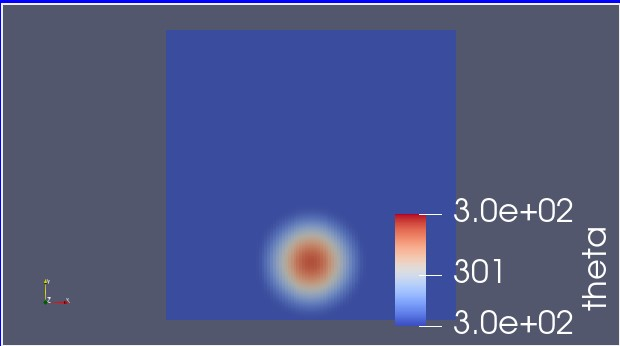

t = 600 s
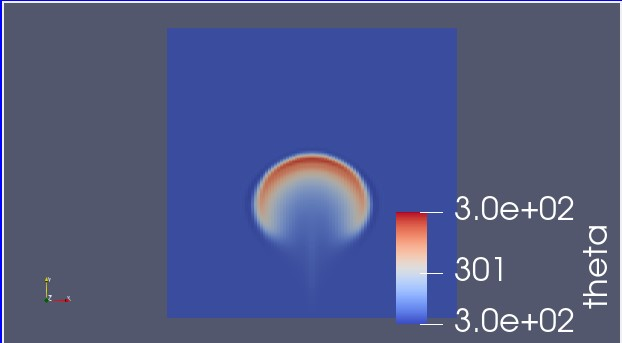

t = 1000 s
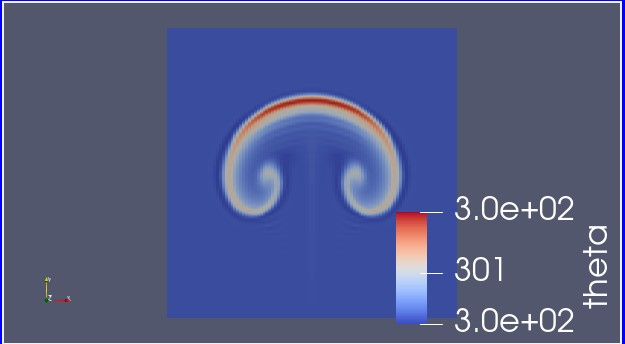